In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
from shapely.geometry import shape
from datetime import date, timedelta
from scipy import stats
import xarray as xr
import xvec
import geopandas as gpd
import netCDF4 as nc4
import dask
import esmpy as ESMF
import xesmf as xe
from cdo import *   # python version
cdo = Cdo()

from nco import *   # python version
nco = Nco()

import statsmodels.api as sm

from glob import glob
import os

import pickle
import json

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /home/jpalmo/.conda/envs/earthdata/share/proj failed


# Burden Calculation

In [2]:
mass_O3 = 48e-3 # kg/mol
mass_air = 28.97e-3 # kg/mol

N_A = 6.022e23

In [3]:
statemet_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_0.9/OutputDir/GEOSChem.StateMet.*.nc4')

In [4]:
speciesconc_1_0_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_1.0/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)
speciesconc_0_9_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_0.9/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)
speciesconc_1_1_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_1.1/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)

In [5]:
trop_burden_o3_1_0 = (speciesconc_1_0_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9
trop_burden_o3_0_9 = (speciesconc_0_9_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9
trop_burden_o3_1_1 = (speciesconc_1_1_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9

# Burden Calculation

In [6]:
mass_O3 = 48e-3 # kg/mol
mass_air = 28.97e-3 # kg/mol

N_A = 6.022e23

In [7]:
statemet_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_0.9/OutputDir/GEOSChem.StateMet.*.nc4')

In [8]:
speciesconc_1_0_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_1.0/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)
speciesconc_0_9_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_0.9/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)
speciesconc_1_1_ds = xr.open_mfdataset('/home/jpalmo/fs09/GEOS-CHEM/GC_rundirs/O3Fire_final/perturbation/scaleBB_1.1/OutputDir/GEOSChem.SpeciesConc.*.nc4',)#engine="h5netcdf",)

In [9]:
speciesconc_1_0_ds.nbytes * 1e-9

14.085094048

In [10]:
trop_burden_o3_1_0 = (speciesconc_1_0_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9
trop_burden_o3_0_9 = (speciesconc_0_9_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9
trop_burden_o3_1_1 = (speciesconc_1_1_ds.SpeciesConcVV_O3 * statemet_ds.Met_AD).isel(lev=slice(0,35)).sum(dim=["lev"]).sum(dim=["time"]) * mass_O3/mass_air * 1e-9

## Load Population Data

In [11]:
import rioxarray

# Load GeoTIFF file
### population count
# pop_ds = rioxarray.open_rasterio("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/gpw-v4-population-count-rev11_2020_1_deg_tif/gpw_v4_population_count_rev11_2020_1_deg.tif")
# pop_ds = pop_ds.rename({'y': 'lat', 'x': 'lon'})
### population density
pop_ds = rioxarray.open_rasterio("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_1_deg_tif/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.tif")
pop_ds = pop_ds.rename({'y': 'lat', 'x': 'lon'})

In [12]:
pop_ds = pop_ds.where(pop_ds != pop_ds.attrs['_FillValue'], np.nan)

In [13]:
pop_ds = pop_ds.fillna(0)

In [14]:
## regridded population
regrid_pop_ds = xr.open_dataset('/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/regridded_pop.nc')

In [15]:
import xarray as xr
import numpy as np

# Function to calculate the area of each grid cell in km²
def calculate_grid_area(lat, lon):
    R = 6371e3  # Earth's radius in meters
    lat_rad = np.deg2rad(lat)
    lon_diff = np.diff(np.concatenate([lon, [lon[-1] + np.diff(lon)[-1]]]))
    lat_diff = np.diff(np.concatenate([lat, [lat[-1] + np.diff(lat)[-1]]]))
    dlat = np.abs(np.deg2rad(lat_diff))
    dlon = np.abs(np.deg2rad(lon_diff))

    # Calculate the area of each grid cell in m²
    area_m2 = (R ** 2) * dlat[:, np.newaxis] * dlon[np.newaxis, :] * np.cos(lat_rad[:, np.newaxis])

    # Convert to km²
    area_km2 = area_m2 / 1e6
    return area_km2

# Load original and regridded datasets
orig_ds = xr.open_dataset('/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/pop_ds.nc')
regridded_ds = xr.open_dataset('/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/regridded_pop.nc')

# Extract latitude and longitude values
orig_lat = orig_ds['lat'].values
orig_lon = orig_ds['lon'].values
regrid_lat = regridded_ds['lat'].values
regrid_lon = regridded_ds['lon'].values

# Calculate the grid cell area for the original and regridded grids (in km²)
orig_area = calculate_grid_area(orig_lat, orig_lon)
regrid_area = calculate_grid_area(regrid_lat, regrid_lon)

# Multiply population density by the area of each grid cell to get total population
orig_population_total = orig_ds['population'].values * orig_area
regrid_population_total = regridded_ds['population'].values * regrid_area

# Area-weighted sums (i.e., total population)
orig_total_population = np.nansum(orig_population_total)
regrid_total_population = np.nansum(regrid_population_total)

# Print results
print(f"Original Total Population (Area-Weighted): {orig_total_population:.2f}")
print(f"Regridded Total Population (Area-Weighted): {regrid_total_population:.2f}")

# Check if population is conserved
if np.isclose(orig_total_population, regrid_total_population, rtol=1e-2):
    print("Population is conserved!")
else:
    print("Population is not conserved.")


Original Total Population (Area-Weighted): 13041237322.45
Regridded Total Population (Area-Weighted): 13124860041.97
Population is conserved!


In [16]:
regrid_population_total = regridded_ds['population'] * regrid_area

In [17]:
### ORIGINAL GRID
# Calculate the grid cell area
orig_grid_area = calculate_grid_area(orig_lat, orig_lon)

# Total area of all grid cells
orig_total_area = np.nansum(orig_grid_area)

### REGRIDDED GRID
# Calculate the grid cell area
regrid_grid_area = calculate_grid_area(regrid_lat, regrid_lon)

# Total area of all grid cells
regrid_total_area = np.nansum(regrid_grid_area)

## Tropospheric Burden

In [18]:
(100*10*((((trop_burden_o3_1_1 - trop_burden_o3_1_0)+(trop_burden_o3_1_0 - trop_burden_o3_0_9))/2)/ trop_burden_o3_1_0))

<xarray.DataArray (lat: 91, lon: 144)> Size: 52kB
dask.array<mul, shape=(91, 144), dtype=float32, chunksize=(91, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 728B -89.5 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 89.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

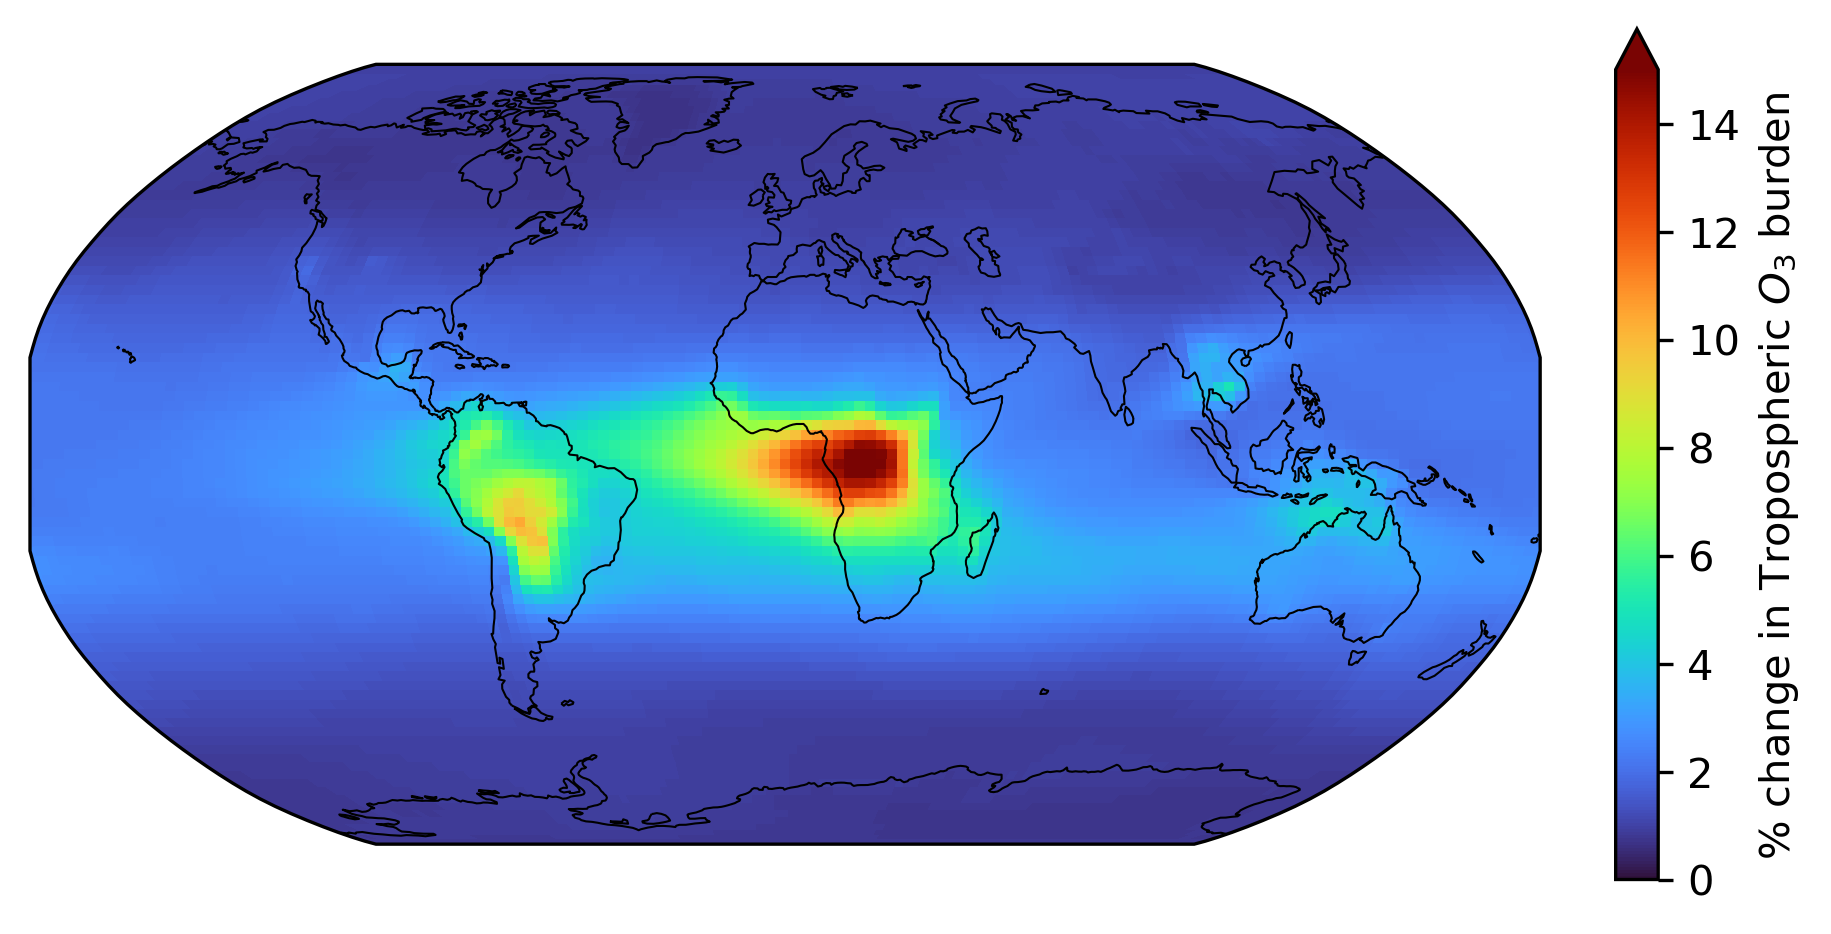

In [19]:
fig, ax = plt.subplots(
        figsize=(6, 3), dpi=300, 
        constrained_layout=True,
        subplot_kw={"projection": ccrs.Robinson()}
    )

ax.coastlines(color="black", linewidth=0.5)
country_borders = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_boundary_lines_land",
    scale="50m",
    facecolor="none",
)

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title('',)

# (100*10*((map_conc_o3_1_1 - map_conc_o3_1_0) / map_conc_o3_1_0)).plot(ax=ax, cmap='turbo', vmin=1, vmax=15, cbar_kwargs={'label': '% change in Tropospheric $O_3$ burden'})
(100*10*((((trop_burden_o3_1_1 - trop_burden_o3_1_0)+(trop_burden_o3_1_0 - trop_burden_o3_0_9))/2)/ trop_burden_o3_1_0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', vmin=0, vmax=15, cbar_kwargs={'label': '% change in Tropospheric $O_3$ burden'})

# Surface Concentrations

In [20]:
surface_conc_o3_1_0 = (speciesconc_1_0_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9
surface_conc_o3_0_9 = (speciesconc_0_9_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9
surface_conc_o3_1_1 = (speciesconc_1_1_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9

In [21]:
# Apply masking to ensure zeros are treated as NaN (for white color in plot)
surface_conc_data = (10 * (((surface_conc_o3_1_1 - surface_conc_o3_1_0) + (surface_conc_o3_1_0 - surface_conc_o3_0_9)) / 2))

In [22]:
surface_conc_data = surface_conc_data.where(surface_conc_data != 0)
surface_conc_o3_1_0 = surface_conc_o3_1_0.where(surface_conc_o3_1_0 != 0)

# Surface Concentrations

In [23]:
surface_conc_o3_1_0 = (speciesconc_1_0_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9
surface_conc_o3_0_9 = (speciesconc_0_9_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9
surface_conc_o3_1_1 = (speciesconc_1_1_ds.SpeciesConcVV_O3).isel(lev=0).isel(time=slice(6,10)).mean(dim=["time",]) * 1e9

In [24]:
# Apply masking to ensure zeros are treated as NaN (for white color in plot)
surface_conc_data = (10 * (((surface_conc_o3_1_1 - surface_conc_o3_1_0) + (surface_conc_o3_1_0 - surface_conc_o3_0_9)) / 2))

In [25]:
surface_conc_data = surface_conc_data.where(surface_conc_data != 0)
surface_conc_o3_1_0 = surface_conc_o3_1_0.where(surface_conc_o3_1_0 != 0)

In [26]:
(100* surface_conc_data / surface_conc_o3_1_0).nbytes

52416

In [27]:
(100* surface_conc_data / surface_conc_o3_1_0).mean().values

array(4.114917, dtype=float32)

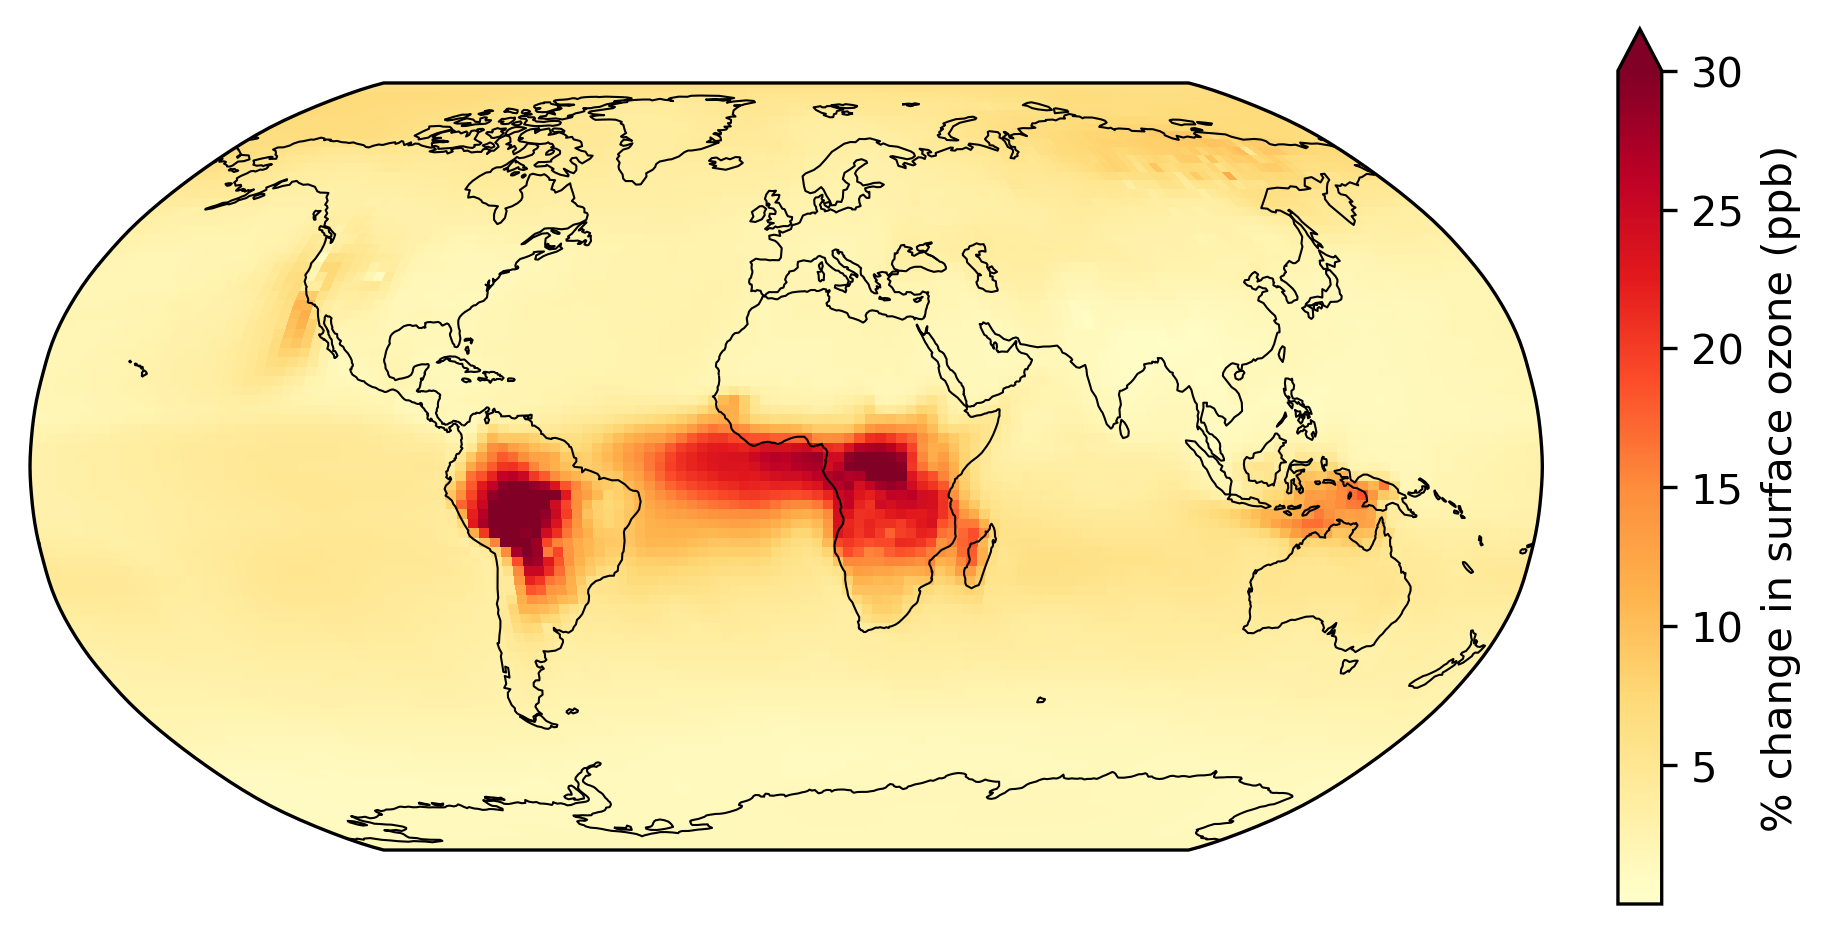

In [28]:
# Define a custom colormap where zero is white
cmap = plt.get_cmap('YlOrRd')  # Start with YlOrRd
cmap.set_under('white')  # Make values below the colormap range white
fig, ax = plt.subplots(
        figsize=(6, 3), dpi=300, 
        constrained_layout=True,
        subplot_kw={"projection": ccrs.Robinson()}
    )

ax.coastlines(color="black", linewidth=0.5)
country_borders = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_boundary_lines_land",
    scale="50m",
    facecolor="none",
)

# ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_global()

# cbar_kwargs={'label': ' \n exposure difference (ppb/million people)'}

(100* surface_conc_data / surface_conc_o3_1_0).plot(ax=ax, cmap=cmap, vmin=0.001, vmax=30, cbar_kwargs={'label': '% change in surface ozone (ppb)'}, transform=ccrs.PlateCarree(),)
ax.set_title('',)
plt.show()

# Population Weighted Surface Exposure

In [29]:
# Apply masking to ensure zeros are treated as NaN (for white color in plot)
pop_weighted_data = (10 * (((surface_conc_o3_1_1 - surface_conc_o3_1_0) + (surface_conc_o3_1_0 - surface_conc_o3_0_9)) / 2))* (regrid_population_total / regrid_total_population)

In [30]:
pop_weighted_base = surface_conc_o3_1_0 * (regrid_population_total / regrid_total_population)

## Show outlines

In [31]:
continents_gdf = gpd.read_file("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/continents.json")

In [32]:
# Create a new row with the WUS geometry and continent name 'WUS'
wus_gdf = gpd.read_file("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/WUS.geojson")
new_row = {'continent': 'WUS', 'geometry': wus_gdf.geometry.iloc[0]}
continents_gdf = pd.concat([continents_gdf, gpd.GeoDataFrame(new_row, index=[0])], ignore_index=True)

In [33]:
# Create a new row with the WUS geometry and continent name 'WUS'
africa_gdf = gpd.read_file("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/Cafrica.geojson")
new_row = {'continent': 'SAfrica', 'geometry': africa_gdf.geometry.iloc[0]}
continents_gdf = pd.concat([continents_gdf, gpd.GeoDataFrame(new_row, index=[0])], ignore_index=True)

In [34]:
# Create a new row with the WUS geometry and continent name 'WUS'
africa_gdf = gpd.read_file("/home/jpalmo/fs09/Projects/O3Fire/model_eval/perturbation/Wafrica.geojson")
new_row = {'continent': 'WAfrica', 'geometry': africa_gdf.geometry.iloc[0]}
continents_gdf = pd.concat([continents_gdf, gpd.GeoDataFrame(new_row, index=[0])], ignore_index=True)

In [35]:
# Convert multipolygons to boundaries
continents_gdf["boundary"] = continents_gdf.geometry.boundary

# Create a new GeoDataFrame for the boundaries
continents_gdf = gpd.GeoDataFrame(continents_gdf.drop(columns="geometry"), geometry=continents_gdf["boundary"])

In [36]:
continents_gdf.to_csv("/home/jpalmo/fs09/Projects/O3Fire/paper/data/outlines.csv", index=False)

In [37]:
continents_gdf.memory_usage(deep=True).sum()

849

In [38]:
continent_colors = {
                    'africa': 'tab:red',
                    'asia': 'tab:green',
                    'europe': 'tab:purple',
                    'northAmerica': 'tab:blue',
                    'oceania': 'tab:orange',
                    'southAmerica': 'tab:brown',
                    'WUS': 'k',
                    'SAfrica': 'k',
                    'WAfrica': 'k',
                    }

continent_linestyles = {
                    'africa': '-',
                    'asia': '-',
                    'europe': '-',
                    'northAmerica': '-',
                    'oceania': '-',
                    'southAmerica': '-',
                    'WUS': ':',
                    'SAfrica': '-.',
                    'WAfrica': '--',
                    }

continent_linewidths = {
                    'africa': 0.5,
                    'asia': 0.5,
                    'europe': 0.5,
                    'northAmerica': 0.5,
                    'oceania': 0.5,
                    'southAmerica': 0.5,
                    'WUS': 1,
                    'SAfrica': 1,
                    'WAfrica': 1,
                    }

continent_labels = {
                    'africa': 'Africa',
                    'asia': 'Asia',
                    'europe': 'Europe',
                    'northAmerica': 'North \n America',
                    'oceania': 'Oceania',
                    'southAmerica': 'South \n America',
                    'WUS': 'Western \n US',
                    'SAfrica': 'South \n Africa',
                    'WAfrica': 'West \n Africa',
                    }

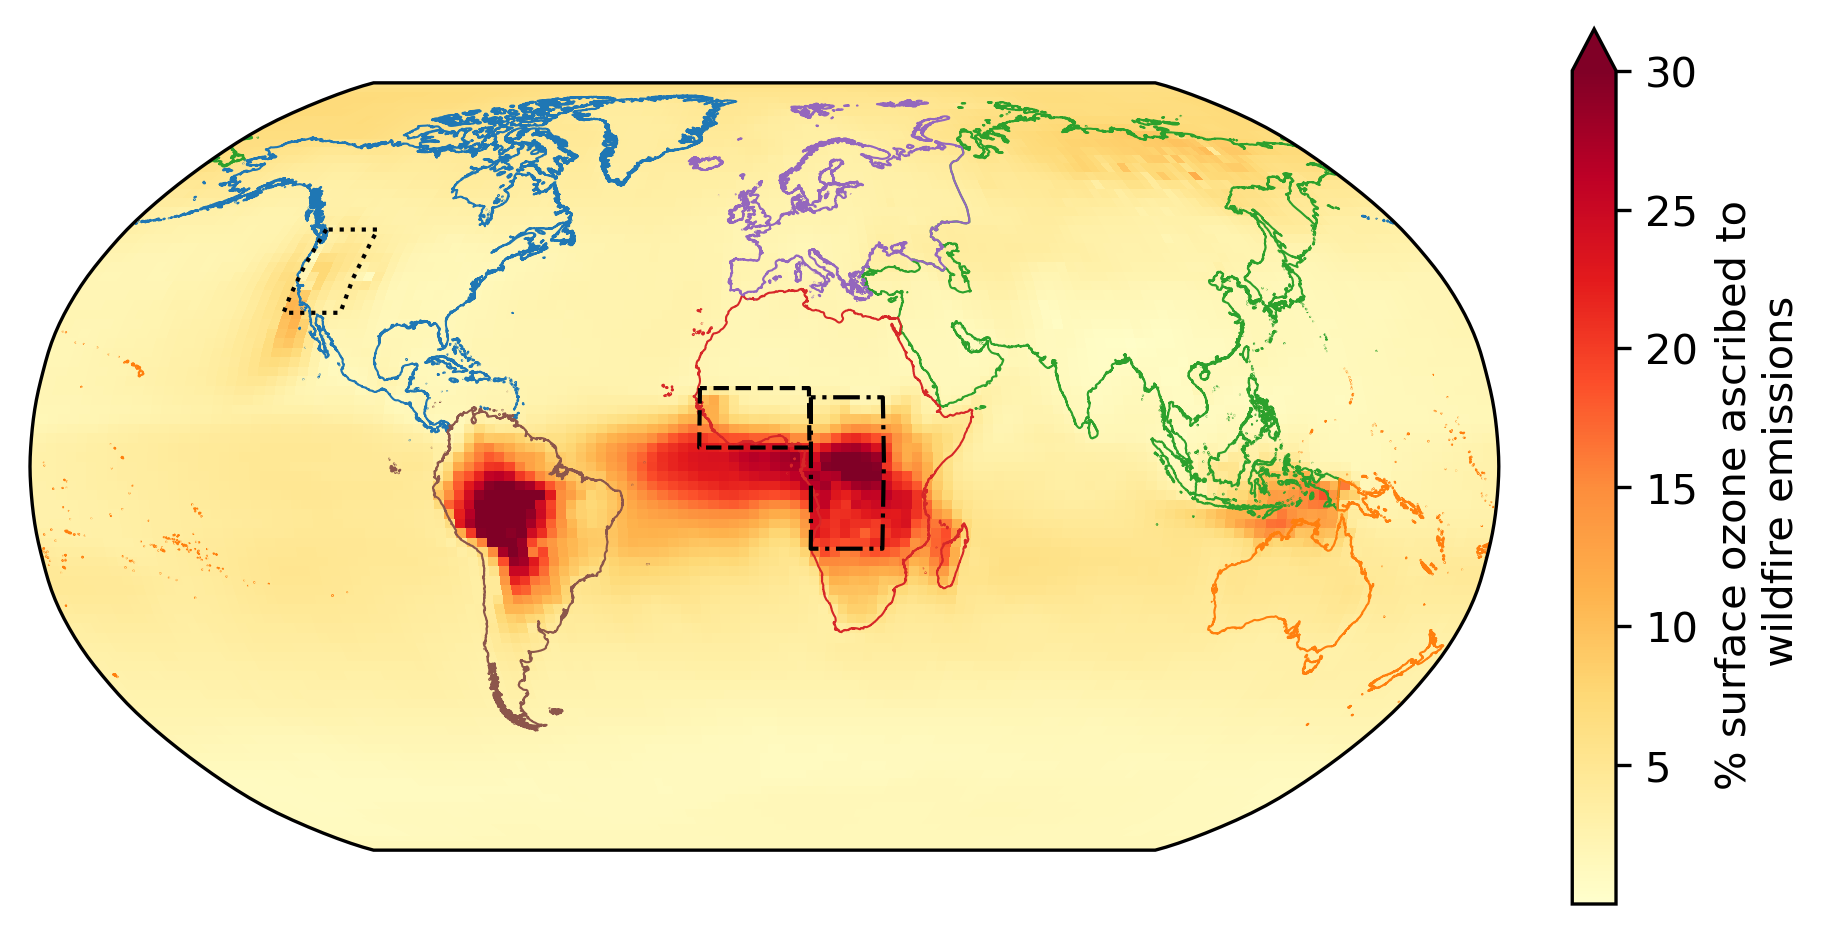

In [39]:
fig, ax = plt.subplots(
        figsize=(6, 3), dpi=300, 
        constrained_layout=True,
        subplot_kw={"projection": ccrs.Robinson()}
    )

# (100*pop_weighted_data/pop_weighted_base).plot(ax=ax, cmap=cmap, vmin=0, vmax=25, cbar_kwargs={'label': "% surface ozone ascribed to \n wildfire emissions"}, transform=ccrs.PlateCarree(),)
(100* surface_conc_data / surface_conc_o3_1_0).plot(ax=ax, cmap=cmap, vmin=0.001, vmax=30, cbar_kwargs={'label': '% surface ozone ascribed to \n wildfire emissions'}, transform=ccrs.PlateCarree(),)

# Plot geometries with different colors based on the "name" column
continents_gdf.plot(ax=ax, transform=ccrs.PlateCarree(),
                    edgecolor = continents_gdf["continent"].map(continent_colors),
                    facecolor = "none",
                    linestyle = continents_gdf["continent"].map(continent_linestyles),
                    linewidth = continents_gdf["continent"].map(continent_linewidths),
                    alpha = 1,
                    legend=True, figsize=(10, 6))

ax.set_title('',)
plt.show()

## Bar Plot

In [40]:
# put ozone total exposure and ozone fire exposure into the same xarray Dataset
ozone_exposure = xr.Dataset(
    {
        "ozone_total_exposure": pop_weighted_base,
        "ozone_fire_exposure": pop_weighted_data,
        # "ozone_total_exposure": surface_conc_o3_1_0,
        # "ozone_fire_exposure": surface_conc_data,
    }
)

In [41]:
# Register xvec accessor with your dataset
ozone_exposure = ozone_exposure.xvec

In [42]:
# Calculate fire fraction per continent
fire_fraction = {}
for continent_name, continent_shape in zip(continents_gdf['continent'], continents_gdf.geometry):
    # Apply continent shape mask
    try:
        masked_ds = ozone_exposure.zonal_stats(continent_shape.geoms, x_coords="lon", y_coords="lat",)
    except:
        masked_ds = ozone_exposure.zonal_stats([continent_shape], x_coords="lon", y_coords="lat",)

    # Calculate fraction and take the mean
    fire_fraction[continent_name] = (masked_ds['ozone_fire_exposure'] / masked_ds['ozone_total_exposure']).mean()
    # fire_fraction[continent_name] = (masked_ds['ozone_fire_exposure']).mean()

In [43]:
keys = np.array([k for k in fire_fraction.keys()])
values = np.array([f.values for f in fire_fraction.values()])*100

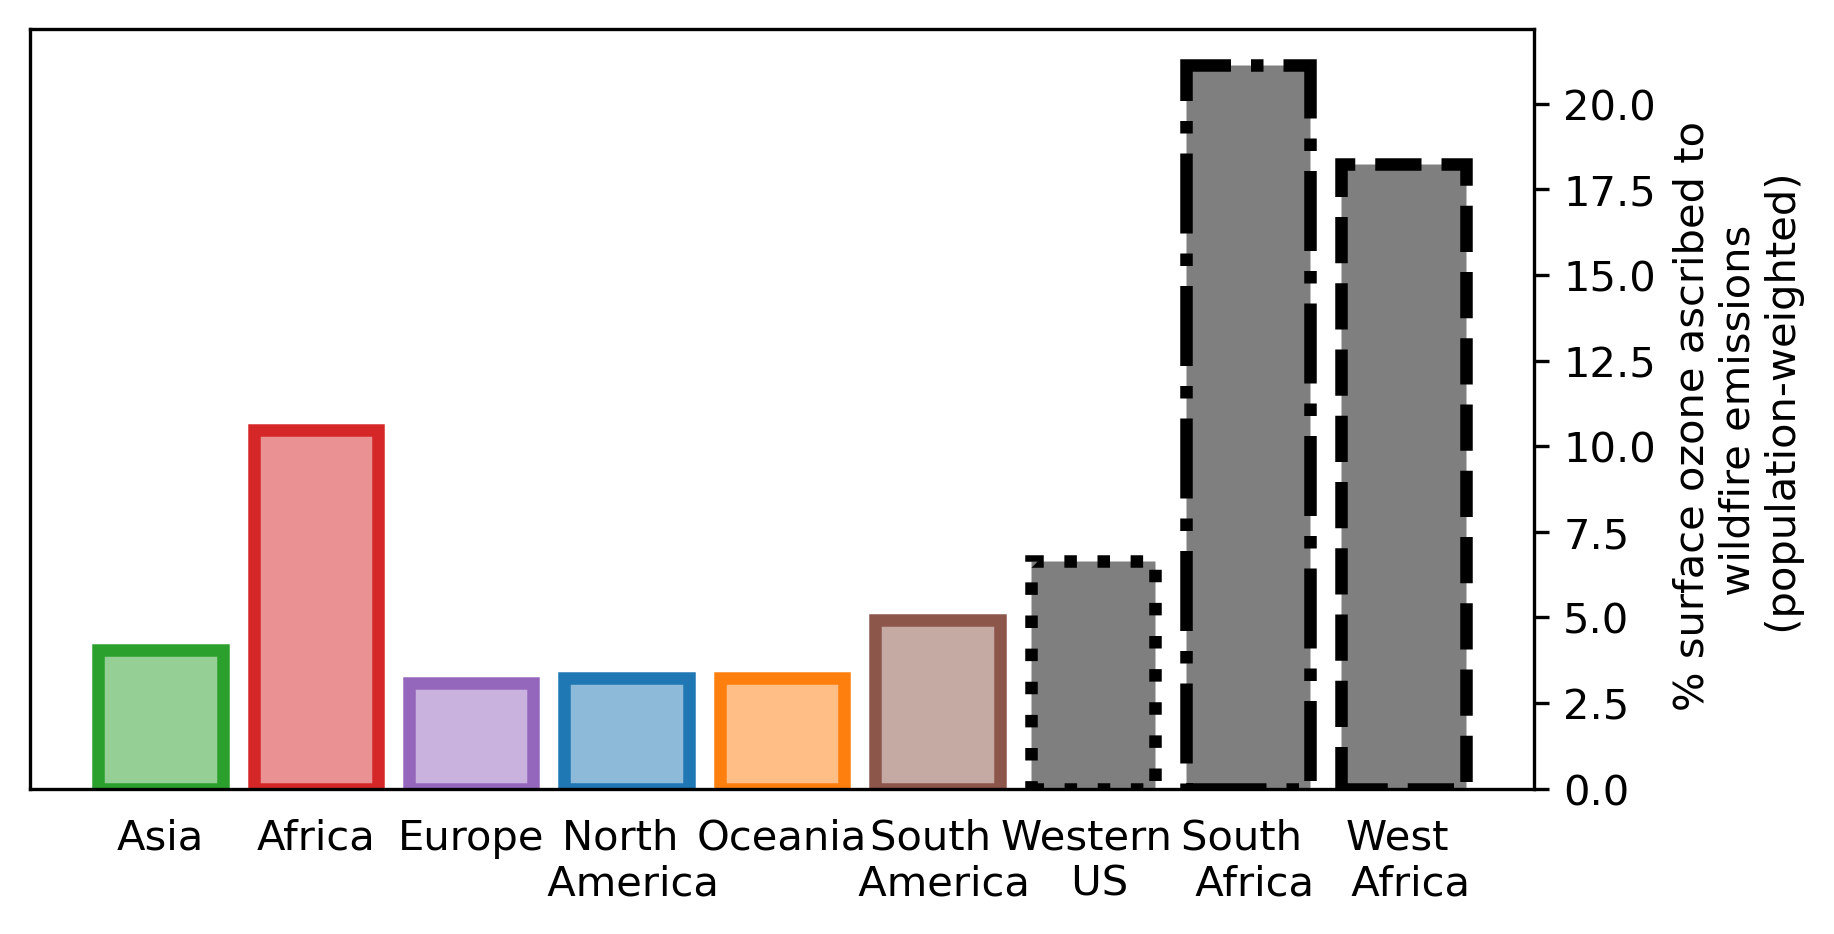

In [44]:
# make bar plot colored by continent
fig, ax = plt.subplots(figsize=(6, 3), dpi=300, constrained_layout=True)

# Create a bar plot
bars = ax.bar(keys, values, color=[continent_colors[continent] for continent in fire_fraction.keys()],)

# Change the line style for each bar
for bar, continent in zip(bars, fire_fraction.keys()):
    # Get the original color and add alpha to it
    face_color = continent_colors[continent]  # Original facecolor
    bar.set_facecolor((*plt.matplotlib.colors.to_rgb(face_color), 0.5))  # Set alpha=0.5
    bar.set_edgecolor(continent_colors[continent])  # Outline color
    bar.set_linestyle(continent_linestyles[continent])  # Outline linestyle
    bar.set_linewidth(3)  # Outline thickness
    # set axis tick labels to continent_labels
    ax.set_xticklabels([continent_labels[continent] for continent in fire_fraction.keys()], rotation=0)
    # remove x ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    

# move y axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("% surface ozone ascribed to \n wildfire emissions \n (population-weighted)")
plt.show()

# Plot

### Figure 9

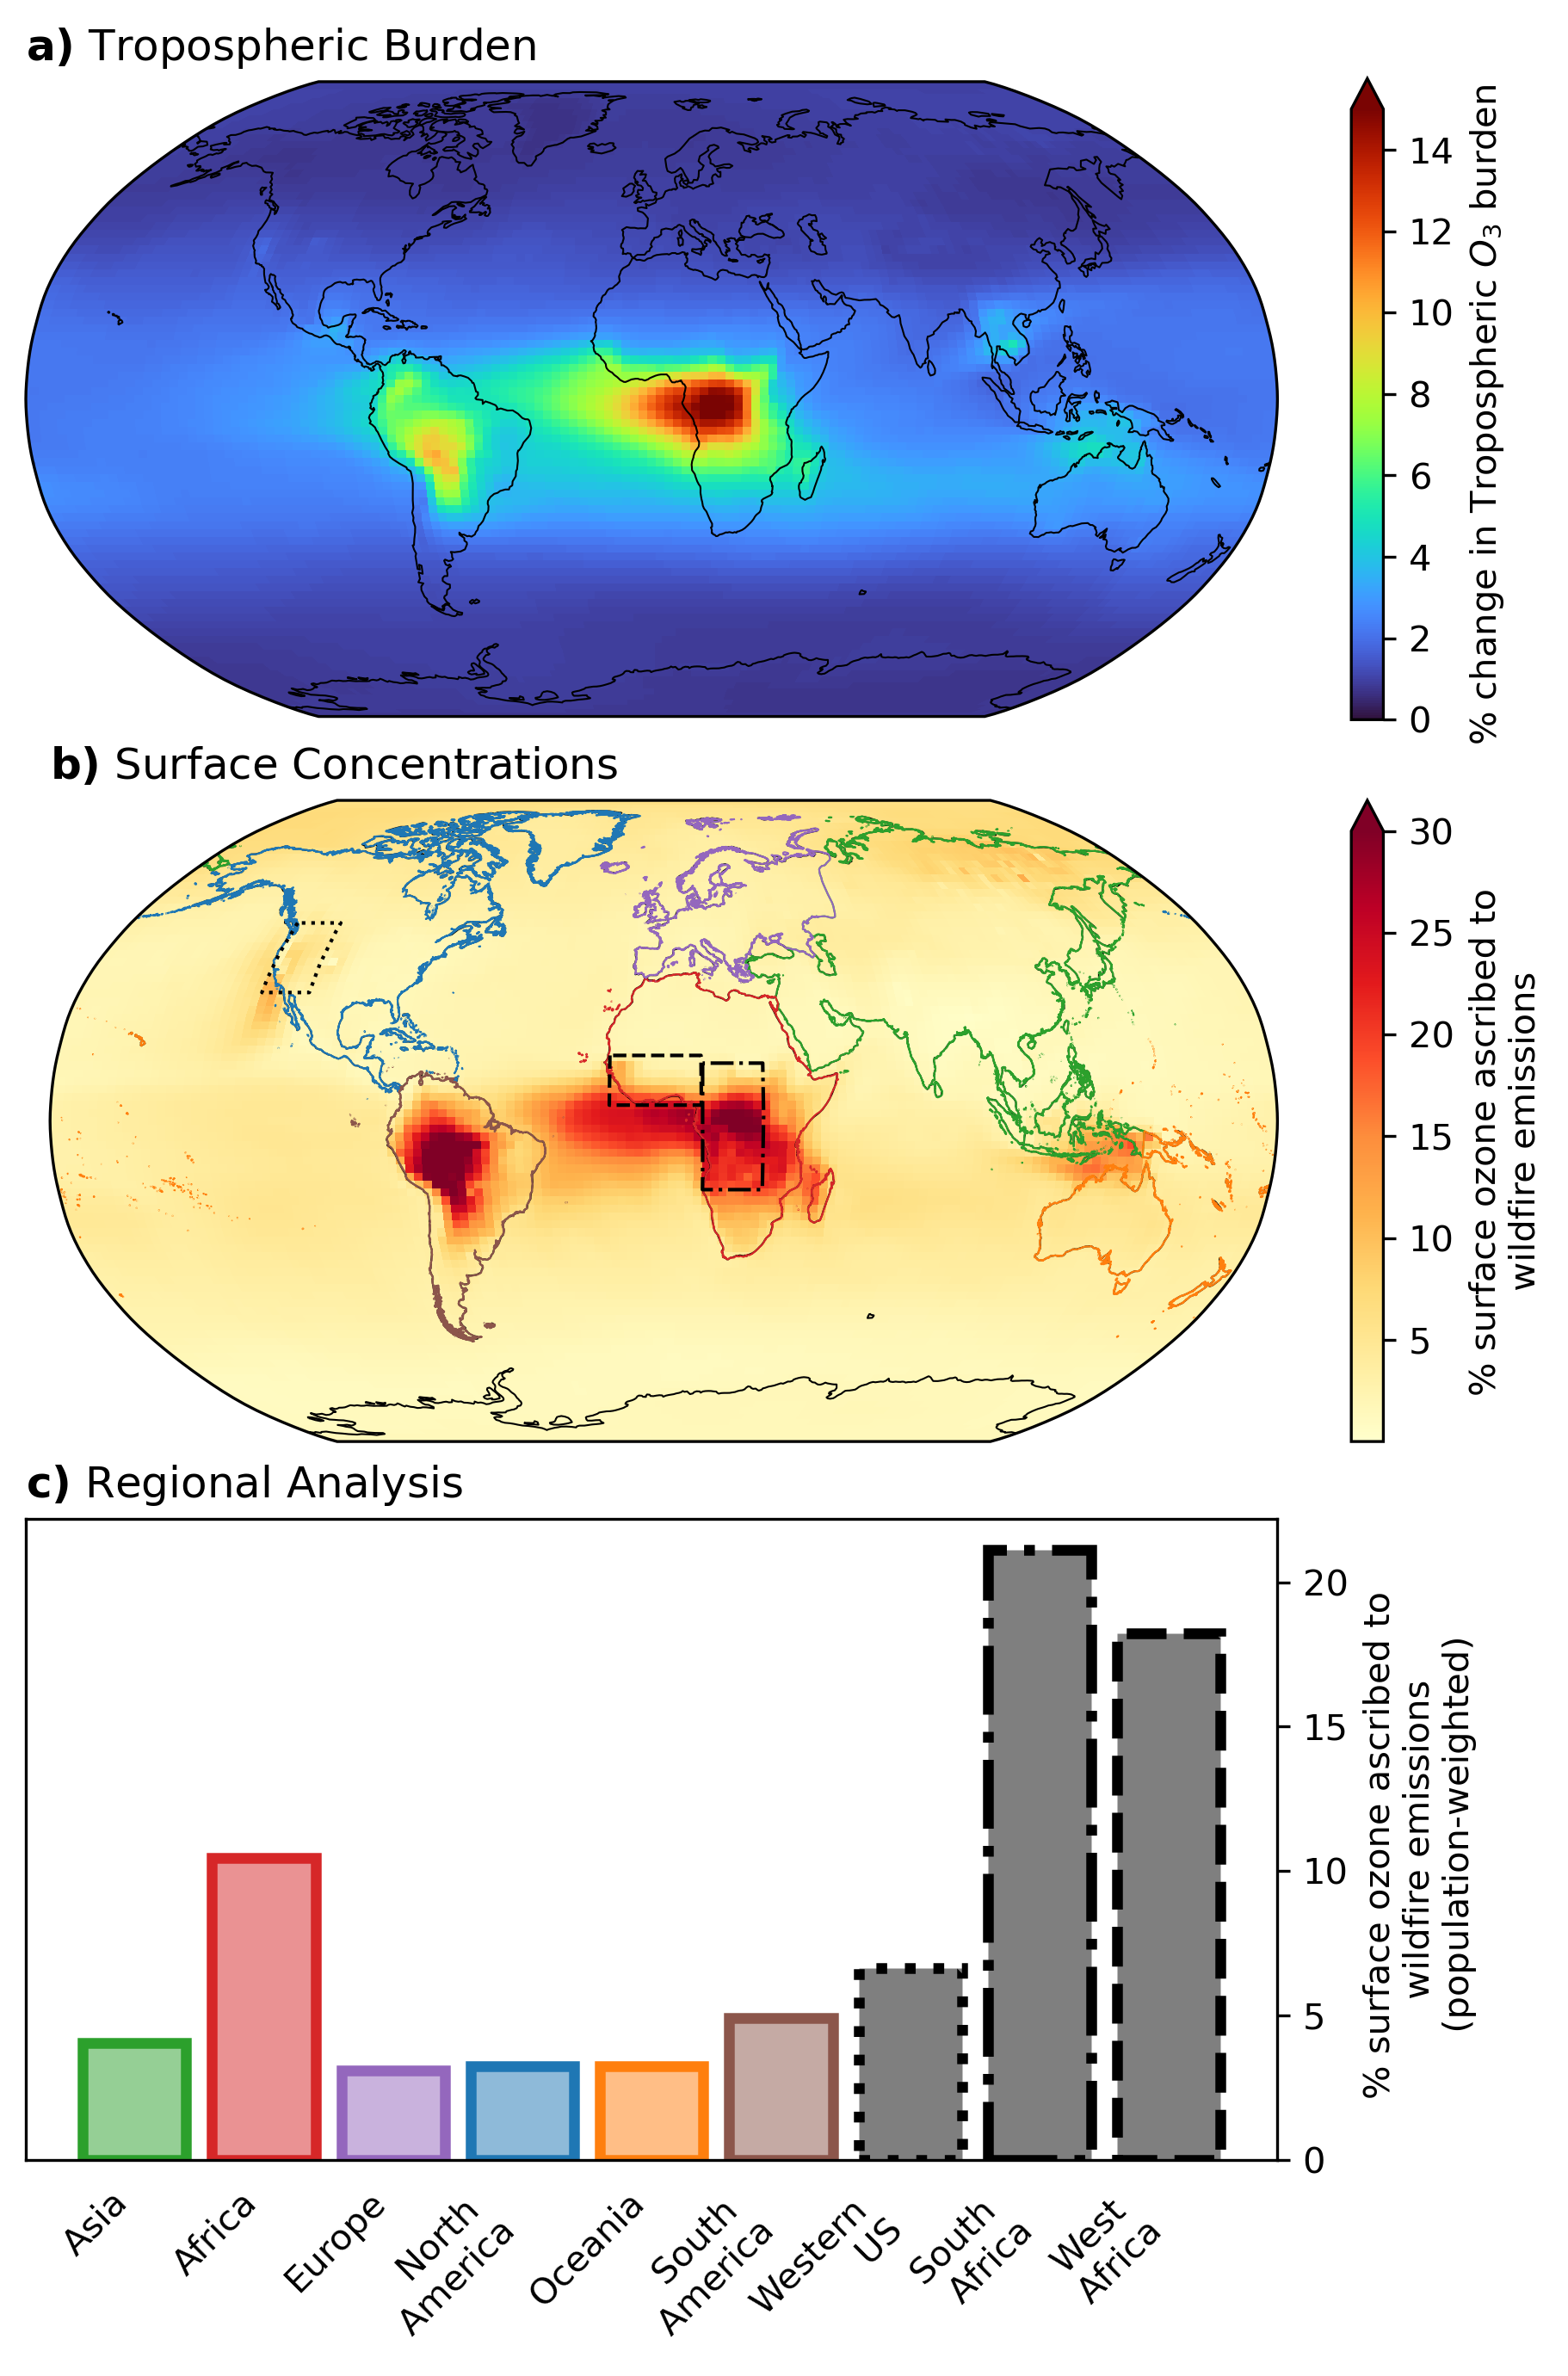

In [48]:

fig = plt.figure(figsize=(6, 9), dpi=300, constrained_layout=True)

# Create three subplots
gs = fig.add_gridspec(3, 1)

# Panel a: Tropospheric burden
ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson())
ax1.coastlines(color="black", linewidth=0.5)
ax1.set_global()
(100*10*((((trop_burden_o3_1_1 - trop_burden_o3_1_0)+(trop_burden_o3_1_0 - trop_burden_o3_0_9))/2)/ trop_burden_o3_1_0)).plot(
    ax=ax1, 
    transform=ccrs.PlateCarree(), 
    cmap='turbo', 
    vmin=0, 
    vmax=15, 
    cbar_kwargs={'label': '% change in Tropospheric $O_3$ burden', 'pad': -0.1}
)
ax1.set_title(r'$\bf{a)}$ Tropospheric Burden', loc='left')

# Panel b: Surface concentrations
ax2 = fig.add_subplot(gs[1], projection=ccrs.Robinson())
ax2.coastlines(color="black", linewidth=0.5)
ax2.set_global()
(100* surface_conc_data / surface_conc_o3_1_0).plot(
    ax=ax2, 
    cmap=cmap, 
    vmin=0.001, 
    vmax=30, 
    cbar_kwargs={'label': '% surface ozone ascribed to \n wildfire emissions', 'pad': -0.1}, 
    transform=ccrs.PlateCarree()
)
# Plot geometries with different colors based on the "name" column
continents_gdf.plot(ax=ax2, transform=ccrs.PlateCarree(),
                    edgecolor = continents_gdf["continent"].map(continent_colors),
                    facecolor = "none",
                    linestyle = continents_gdf["continent"].map(continent_linestyles),
                    linewidth = continents_gdf["continent"].map(continent_linewidths),
                    alpha = 1,
                    legend=True, figsize=(10, 6))
ax2.set_title('')
ax2.set_title(r'$\bf{b)}$ Surface Concentrations', loc='left')

# Panel c: Bar plot
ax3 = fig.add_subplot(gs[2])
bars = ax3.bar(keys, values, color=[continent_colors[continent] for continent in fire_fraction.keys()])
for bar, continent in zip(bars, fire_fraction.keys()):
    face_color = continent_colors[continent]
    bar.set_facecolor((*plt.matplotlib.colors.to_rgb(face_color), 0.5))
    bar.set_edgecolor(continent_colors[continent])
    bar.set_linestyle(continent_linestyles[continent])
    bar.set_linewidth(3)
ax3.set_xticklabels([continent_labels[continent] for continent in fire_fraction.keys()], rotation=45, ha='right')
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel("% surface ozone ascribed to \n wildfire emissions \n (population-weighted)")
ax3.set_title(r'$\bf{c)}$ Regional Analysis', loc='left')

#save figure as pdf
plt.savefig("../../figures/fig_09.pdf", bbox_inches='tight', dpi=300)
plt.show()